In [1]:
import numpy as np
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
def normalize(v):
    return v / np.linalg.norm(v)

def cosine(v, u):
    return (normalize(v) * normalize(u)).sum()

In [3]:
RANDOM_SEED = 42

In [4]:
embeddings = []
tokens = []

for line in tqdm(open('../../jb-data/models/fullmodel.vec', 'r').readlines()[1:]):
    line = line.strip()
    token, *nums = line.split()
    nums = np.array(list(map(float, nums)))
    tokens.append(token)
    embeddings.append(nums)

100%|██████████| 114288/114288 [00:02<00:00, 45175.26it/s]


In [5]:
embeddings = np.array(embeddings)
embeddings.shape

(114288, 100)

In [6]:
embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)

In [7]:
def run_kmeans(n_clusters, embedding, init='k-means++', normalize=False):
    if normalize:
        embedding = embedding.copy() / np.linalg.norm(embedding, axis=1, keepdims=True)
    clusterizer = KMeans(n_clusters, init=init, random_state=RANDOM_SEED).fit(embedding)
    labels = clusterizer.predict(embedding)
    return clusterizer, labels

In [8]:
def print_closest(ind, k=20):
    print(f"Library: {tokens[ind]}")
    for other in list(reversed(np.argsort(cosine_sims[ind])))[:k]:
        print(f"{tokens[other]} | {cosine_sims[ind,other]:.4f}")

In [9]:
def compute_score(embeddings, cluster_centers):
    return embeddings.dot(cluster_centers.T).max(axis=1).sum()

In [40]:
N_CLUSTERS = 64

In [41]:
kmeans, labels = run_kmeans(N_CLUSTERS, embeddings)

In [42]:
tokens_counter = pickle.load(open('../../jb-data/extracted_data/concatenated_data/tokens_counter.pkl', 'rb'))
tokens_counter = np.array([tokens_counter[token] for token in tokens])

In [43]:
tokens = np.array(tokens)

In [44]:
cluster_labels = [''] * N_CLUSTERS
cluster_repos = [''] * N_CLUSTERS

for c in range(N_CLUSTERS):
    inds = np.where(labels == c)[0]
    sorted_by_freq = list(reversed(np.argsort(tokens_counter[inds])))

    print('~'*20)
    print(f'Cluster {c}:')
    for ind in sorted_by_freq[:10]:
        true_ind = inds[ind]
        print(f'{tokens[true_ind]} {cosine(embeddings[true_ind], kmeans.cluster_centers_[c]):.3f}')
        cluster_labels[c] += " | " + tokens[true_ind]
    print('~'*20)
    print()

~~~~~~~~~~~~~~~~~~~~
Cluster 0:
address 0.399
os 0.591
addr 0.507
ret 0.347
cv 0.282
fd 0.582
unix 0.439
jlong 0.494
socket 0.513
signal 0.456
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~
Cluster 1:
dx 0.497
dy 0.573
xy 0.353
px 0.339
breaking 0.430
sx 0.550
cy 0.505
bw 0.435
ty 0.471
rx 0.469
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~
Cluster 2:
width 0.784
left 0.567
right 0.562
height 0.783
bounds 0.363
point 0.249
column 0.479
row 0.408
rect 0.487
grid 0.499
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~
Cluster 3:
echo 0.537
lineno 0.524
ac 0.381
me 0.262
pyx 0.228
jdk 0.277
flags 0.357
flag 0.358
ext 0.208
grep 0.410
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~
Cluster 4:
xk 0.396
xp 0.461
jd 0.249
wt 0.325
ha 0.372
xt 0.415
rpi 0.311
nv 0.374
ht 0.475
wp 0.341
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~
Cluster 5:
time 0.753
date 0.605
locale 0.308
ms 0.515
stamp 0.359
millis 0.631
times 0.500
timestamp 0.576
duration 0.544
zone 0.527
~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~
Cluster 6:

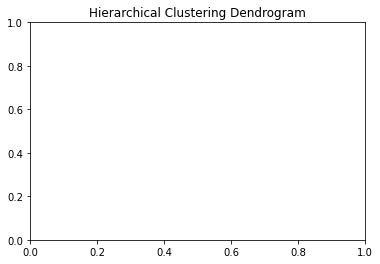

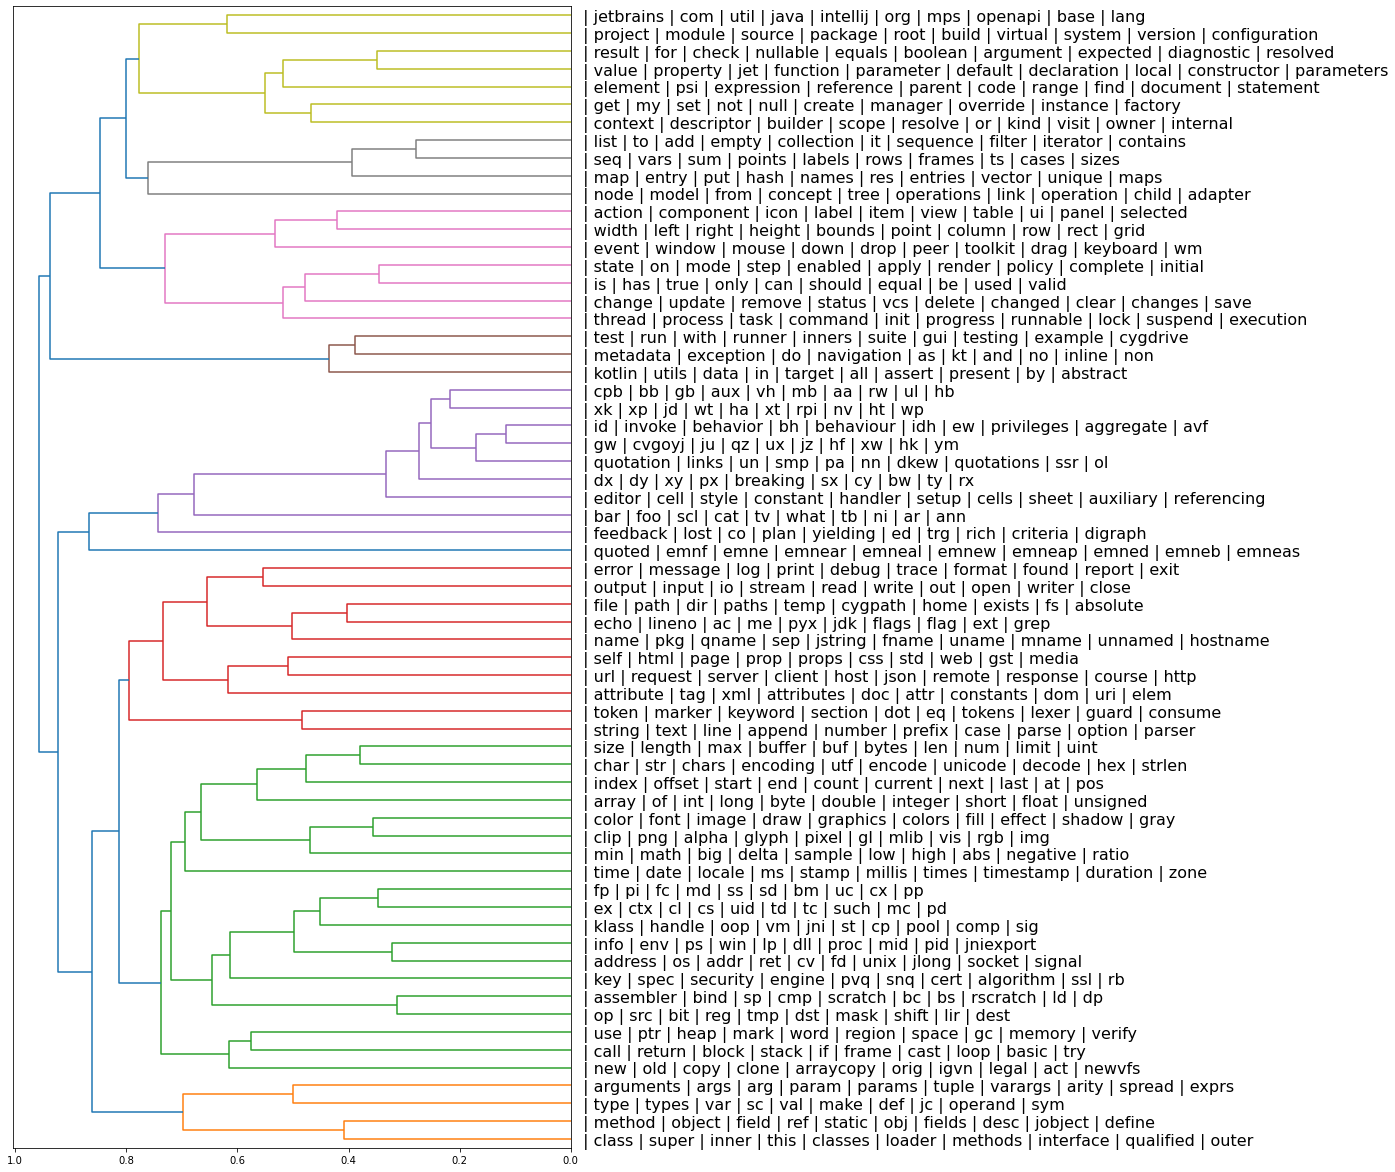

In [45]:
import numpy as np
import pickle

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = kmeans.cluster_centers_
n_clusters = len(X)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model = model.fit(X / np.linalg.norm(X, keepdims=True, axis=1))

plt.title('Hierarchical Clustering Dendrogram')
    # plot the top three levels of the dendrogram
    # plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    # plt.show()
plt.figure(figsize=(10, max(10, n_clusters // 3)))
    # fig = plt.figure()
    # ax = fig.add_subplot(1, 1, 1)
plot_dendrogram(model, truncate_mode='level', p=40, labels=cluster_labels, color_threshold=.8,
                    orientation='left', leaf_font_size=16)
plt.savefig(f'dendrogram.pdf', bbox_inches='tight', dpi=100, format='pdf')

In [46]:
mapping = {token: cluster for token, cluster in zip(tokens, kmeans.labels_)}

In [47]:
pickle.dump(mapping, open('../../jb-data/extracted_data/concatenated_data/mapping_64.pkl', 'wb'))

In [75]:
import os
from collections import Counter

distr = Counter()

root = "../../jb-data/extracted_data/tokenized_code/Arend/"
for cur_root, _, files in os.walk(root):
    for file in files:
        for line in open(os.path.join(cur_root, file)):
            for token in line.split():
                if token in mapping:
                    distr[mapping[token]] += 1

In [76]:
total = sum(distr.values())

In [77]:
for c, count in distr.most_common(20):
    print(f'{count / total:.3f}', cluster_labels[c])
    print()

0.114  | element | psi | expression | reference | parent | code | range | find | document | statement | first | expr | position | body | py | condition | containing | replace | elements | fix

0.102  | get | my | set | not | null | create | manager | override | instance | factory | provider | impl | listener | language | settings | content | template | application | register | search

0.101  | result | for | check | nullable | equals | boolean | argument | expected | diagnostic | resolved | other | bound | inference | flow | binary | order | constraints | substitutor | illegal | compare

0.065  | context | descriptor | builder | scope | resolve | or | kind | visit | owner | internal | symbol | generator | load | visitor | cache | binding | fir | fq | generate | global

0.059  | value | property | jet | function | parameter | default | declaration | local | constructor | parameters | variable | extension | annotation | member | receiver | access | enum | signature | modifier | propertie